In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import requests
import cv2
import PIL.Image
import urllib
print(tf.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0-beta1


<PIL.Image.Image image mode=RGB size=400x400 at 0x14B16A5C0>
(400, 400, 3)


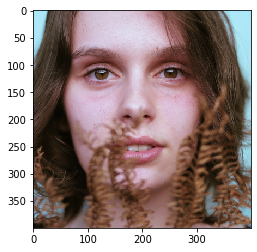

In [124]:
# Get images
def load_img_to_np_array(image_path, show_image = False):
    raw_image = load_img(image_path)
    image_arr = img_to_array(raw_image)
    imaimage_arrge = np.array(image_arr, dtype=float)

    if (show_image):
        plt.figure()
        plt.imshow(raw_image)
    return raw_image, image_arr

woman_image, woman_arr = load_img_to_np_array("woman.jpg", show_image=True)
print(woman_image)
print(woman_arr.shape)

In [135]:
def preprocess_to_lab(image_arr, width = 400, height = 400):
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    X = X.reshape(1, width, height, 1)
    Y = Y.reshape(1, width, height, 2)
    
    return X, Y

In [150]:
input_x, output_y = preprocess_to_lab(woman_arr)
print(input_x.shape)
print(output_y.shape)
print(output_y.min())
print(output_y.max())

(1, 400, 400, 1)
(1, 400, 400, 2)
-0.13980071179795356
0.3145791643609642


In [4]:
# Building the neural network
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(None, None, 1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [68]:
# Finish model
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 8)     80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 32)    0

In [151]:
model.fit(x=input_x, 
    y=output_y,
    batch_size=1,
    epochs=400)

Train on 1 samples
Epoch 1/400
1/1 [==============================] - 1s 713ms/sample - loss: 5.9141e-04 - accuracy: 0.9174
Epoch 2/400
1/1 [==============================] - 0s 264ms/sample - loss: 0.0094 - accuracy: 0.5349
Epoch 3/400
1/1 [==============================] - 0s 238ms/sample - loss: 0.0047 - accuracy: 0.7560
Epoch 4/400
1/1 [==============================] - 0s 288ms/sample - loss: 0.0038 - accuracy: 0.6571
Epoch 5/400
1/1 [==============================] - 0s 231ms/sample - loss: 0.0022 - accuracy: 0.8735
Epoch 6/400
1/1 [==============================] - 0s 223ms/sample - loss: 0.0011 - accuracy: 0.8667
Epoch 7/400
1/1 [==============================] - 0s 215ms/sample - loss: 7.8010e-04 - accuracy: 0.9010
Epoch 8/400
1/1 [==============================] - 0s 251ms/sample - loss: 9.4483e-04 - accuracy: 0.9039
Epoch 9/400
1/1 [==============================] - 0s 233ms/sample - loss: 8.1600e-04 - accuracy: 0.9048
Epoch 10/400
1/1 [==============================] - 0s 2

KeyboardInterrupt: 

In [34]:
loss, accuracy = model.evaluate(X, Y)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy * 100))

1/1 [==============================] - 0s 39ms/sample - loss: 5.9141e-04 - accuracy: 0.9174
initial loss: 0.00
initial accuracy: 91.74


In [71]:
def show_images(original, model_prediction, grayscale):
    
    plt.figure(figsize=(20,20))

    plt.subplot(3,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)
    plt.xlabel("original")

    plt.subplot(3,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayscale, cmap =plt.cm.gray)
    plt.xlabel("grayscale")

    plt.subplot(3,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_prediction)
    plt.xlabel("rgb prediction")

    plt.show()

In [147]:
def predict(original_image, inputX, width = 400, height = 400):
    output = model.predict(inputX)
    output *= 128
    # Output colorizations
    cur = np.zeros((width, height, 3))
    cur[:,:,0] = inputX[0][:,:,0]
    cur[:,:,1:] = output[0]
    
    print(inputX.shape)
    print(output.shape)

    predicted_image = lab2rgb(cur)
    show_images(original_image, predicted_image, rgb2gray(predicted_image))

(1, 400, 400, 1)
(1, 400, 400, 2)


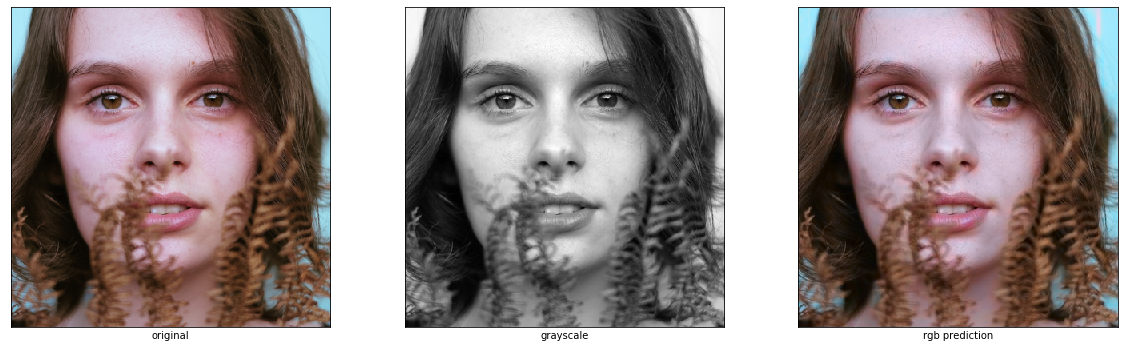

In [148]:
predict(woman_image, input_x)

W0701 10:49:15.563741 4552242624 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


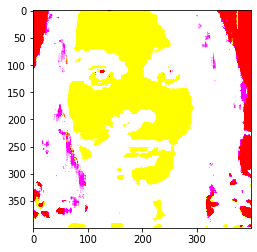

<PIL.Image.Image image mode=RGB size=400x400 at 0x14748FF98>
(400, 400, 3)


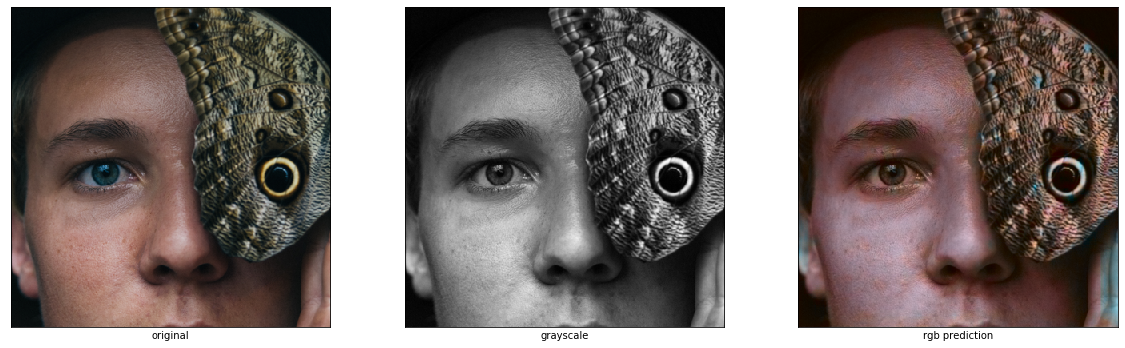

In [136]:
man_image, man_arr = load_img_to_np_array('man.jpg')
print(man_image)
print(man_arr.shape)
man_x, man_y = preprocess_to_lab(man_arr)
predict(man_image, man_x)

In [138]:
man_image, man_arr = load_img_to_np_array('train/img_girlfriend_1.jpg')
print(man_image)
print(man_arr.shape)
man_x, man_y = preprocess_to_lab(man_arr)
predict(man_image, man_x)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x492 at 0x1474DE320>
(492, 350, 3)


ValueError: cannot reshape array of size 172200 into shape (1,192,192,1)